# Backstory

This project is aimed towards identifying patients with the following type of ocular diseases:

**Cataract** - is the clouding of the clear lens of the eye. It develops slowly and is one of the most easy eye abnormalities to detect.

**Glaucoma** - is an eye condition that damages the optic nerve and can be caused due to abnormally high pressure in the eye.

In addition to these the dataset we are working with also covers the following eye-related diseases.

**Diabetes** - is the root cause of 2.6% of blindness worldwide. Diabetic retinopathy is brought on by cumulative long-term harm to the retina's tiny blood vessels.

**AMD** - is an eye disease that can blur your central vision. It happens when aging causes damage to the macula — the part of the eye that controls sharp, straight-ahead vision. 

**Hypertension** - Damage to the retina from high blood pressure is called hypertensive retinopathy. It occurs as the existing high blood pressure causes changes to the microvasculature of the retina.

**Myopia** - Nearsightedness, or myopia, as it is medically termed, is a vision condition in which people can see close objects clearly, but objects farther away appear blurred. Myopia occurs if the eyeball is too long or the cornea (the clear front cover of the eye) is too curved.

It contains other diseases/abnormalities in the label (O) and normal eye images with the label(N).

# Introduction

Given the common nature of the aforementioned issues we want to see how we can get early diagnosis using AI. The goal is to identify patients with Cataract from the images provided in the ODIR dataset using various deep learning (computer-vision) models. The model has also been extened and later fine-tuned to fit the Glaucoma images.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import cv2
import random
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Loading the Dataset

Ocular Disease Intelligent Recognition (ODIR) is an ophthalmic database of 5,000 individuals containing age, color fundus images of the left and right eyes, and diagnostic keywords from doctors. This dataset was gathered by Shanggong Medical Technology Co., Ltd. from various hospitals/medical centers in China. The patients were classified into the following eight labels by trained human readers: Normal (N), Diabetes (D), Glaucoma (G), Cataract (C), Age related Macular Degeneration (A), Hypertension (H), Pathological Myopia (M), Other diseases/abnormalities (O).

In [ ]:
df = pd.read_csv("/content/drive/Shareddrives/BMIN_5220/Code/Dataset/full_df.csv")
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


# Exploratory Data Analysis

## Plot for Age Distribution

[Text(0.5, 1.0, 'Age distribution')]

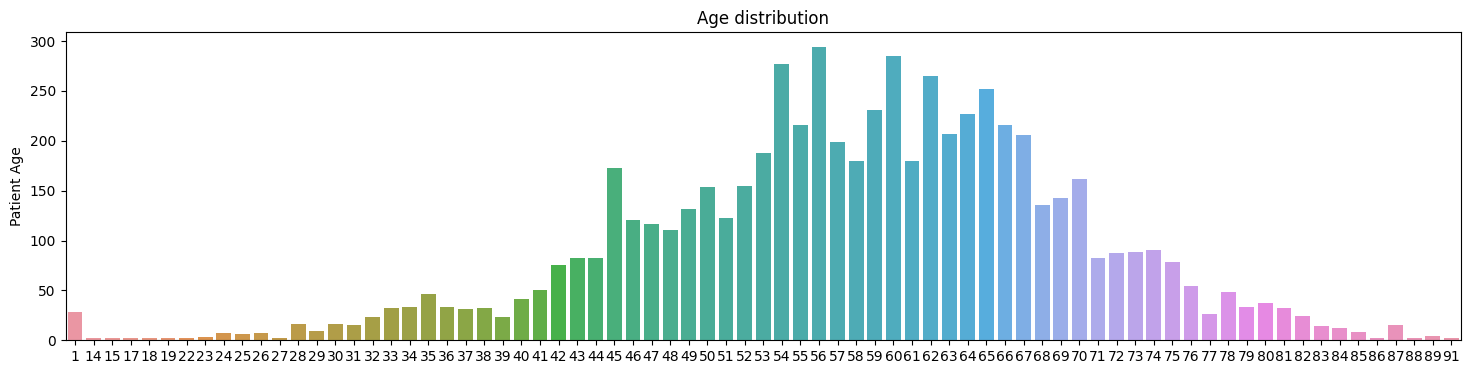

In [ ]:
ages = df['Patient Age'].value_counts()
fig, (ax) = plt.subplots(1, 1, figsize=(18,4))
sns.barplot(x=ages.index, y=ages, ax = ax).set(title = "Age distribution")

## Plot for Gender Distribution

[Text(0.5, 1.0, 'Gender Distribution')]

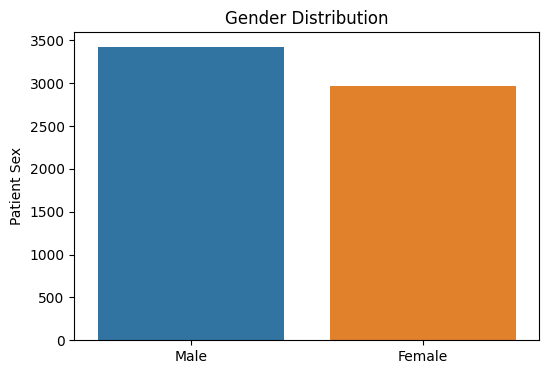

In [ ]:
sex = df['Patient Sex'].value_counts()
fig, (ax) = plt.subplots(1, 1, figsize=(6,4))
sns.barplot(ax=ax, x=sex.index, y=sex).set(title = 'Gender Distribution')

## Plot for Distribution of Diagnisis by the doctor

<ipython-input-6-801f7f6becd4>:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = df['Left-Diagnostic Keywords'].append(df['Right-Diagnostic Keywords'])
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 65292 (\N{FULLWIDTH COMMA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65292 (\N{FULLWIDTH COMMA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


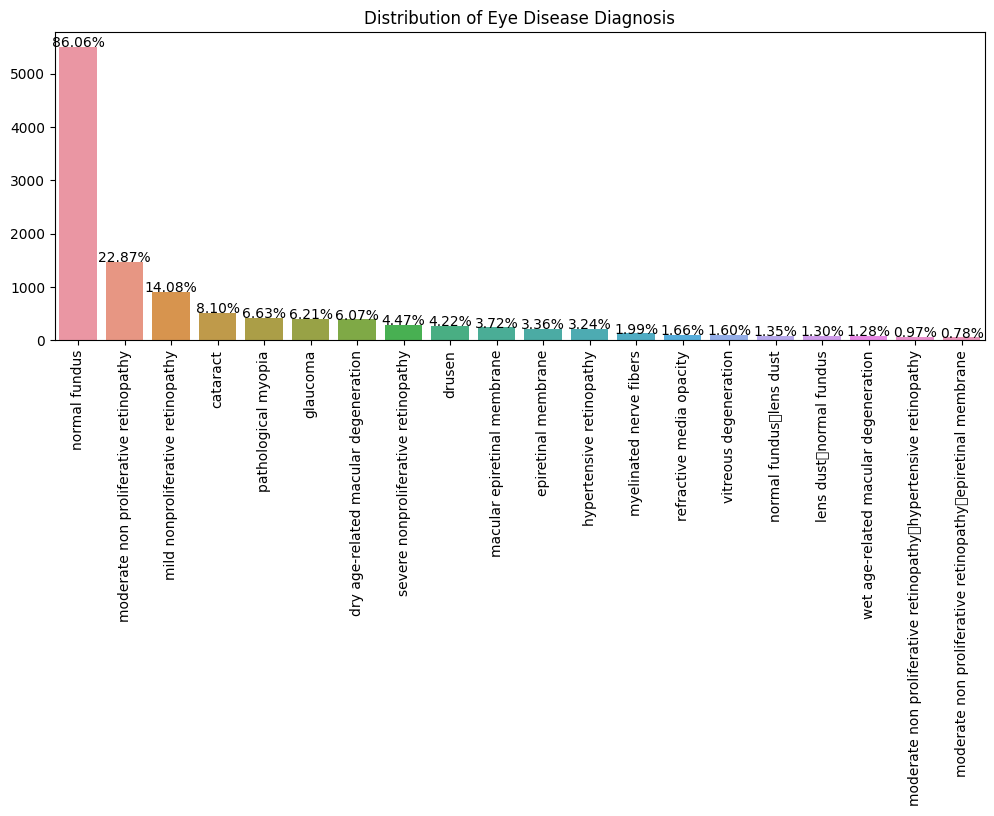

In [ ]:
temp = df['Left-Diagnostic Keywords'].append(df['Right-Diagnostic Keywords'])
ld = temp.value_counts()[:20]
fig, (ax) = plt.subplots(1, 1, figsize=(12,4))
plt.xticks(rotation=90)
sns.barplot(x=ld.index, y=ld, ax = ax).set(title = "Distribution of Eye Disease Diagnosis")
total = float(len(df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.2,
            '{:1.2f}%'.format(100*height/total),
            ha="center")

## Correlation Matrix for Diseases

In [ ]:
co = df.iloc[:,8:15]
correlation = co.T.dot(co)
totals = co.sum()
correlation_2 = correlation / totals 
correlation_2.style.background_gradient().set_precision(2)

<ipython-input-7-06f4a6dd4b1e>:5: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  correlation_2.style.background_gradient().set_precision(2)


,D,G,C,A,H,M,O
D,1.00,0.14,0.18,0.10,0.44,0.12,0.31
G,0.03,1.00,0.01,0.06,0.07,0.04,0.05
C,0.03,0.02,1.00,0.00,0.02,0.00,0.04
A,0.02,0.05,0.00,1.00,0.04,0.01,0.02
H,0.04,0.04,0.01,0.03,1.00,0.00,0.01
M,0.02,0.03,0.00,0.01,0.00,1.00,0.04
O,0.23,0.20,0.14,0.08,0.10,0.19,1.00


## WordCloud of Keywords in Diagnosis

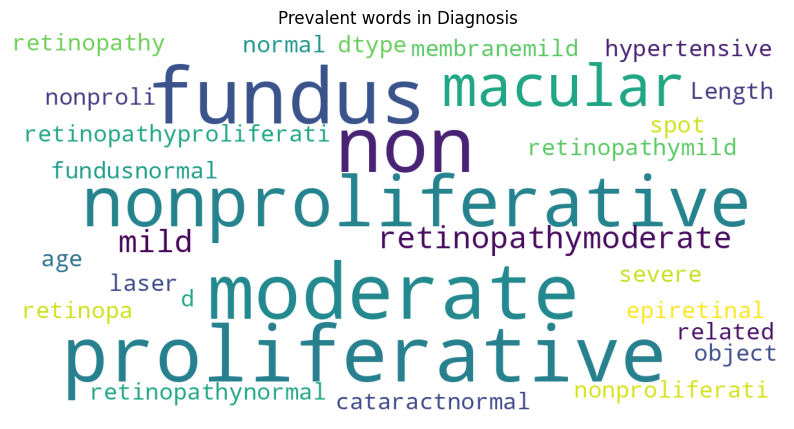

In [ ]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=40,
        max_font_size=40, 
        scale=3,
        random_state=1,
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.title('Prevalent words in Diagnosis')
    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df['Left-Diagnostic Keywords'] + df['Right-Diagnostic Keywords'])

# Data Extraction

## Extracting Information about Cataract & Normal Eye Images from the Dataset

### Cataract Images

In [ ]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [ ]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [ ]:
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
left_cataract[:15]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
       '465_left.jpg', '477_left.jpg', '553_left.jpg', '560_left.jpg',
       '594_left.jpg', '611_left.jpg', '625_left.jpg'], dtype=object)

In [ ]:
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:15]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg'], dtype=object)

In [ ]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


### Normal Images


In [ ]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [ ]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [ ]:
print(len(cataract),len(normal))

594 500


## Creating Dataset from Images

In [ ]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/content/drive/Shareddrives/BMIN_5220/Code/Dataset/preprocessed_images"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [ ]:
dataset = create_dataset(cataract,1)

100%|██████████| 594/594 [02:08<00:00,  4.62it/s] 


In [ ]:
len(dataset)

588

In [ ]:
dataset = create_dataset(normal,0)

100%|██████████| 500/500 [02:28<00:00,  3.37it/s]


In [ ]:
len(dataset)

1088

### Let's see some images

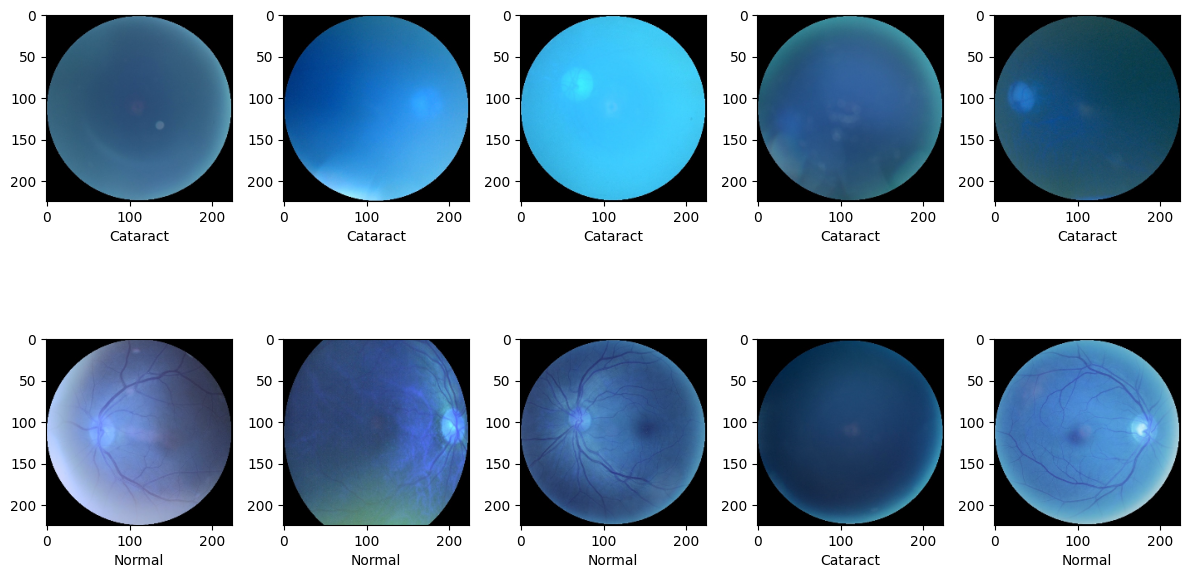

In [ ]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

## Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=5,  # rotation
                                   width_shift_range=0.2,  # horizontal shift
                                   zoom_range=0.2,  # zoom
                                   horizontal_flip=True,  # horizontal flip
                                   brightness_range=[0.2,0.8])  # brightness

### Dividing dataset into x(features) & y(target)

In [ ]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [ ]:
len(x_train)

870

# Modeling

## VGG19 Model

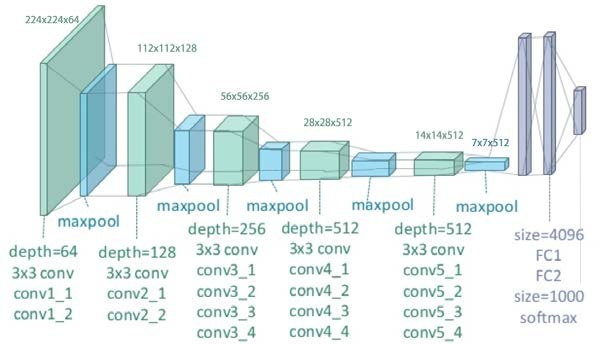

In [ ]:
lr_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
vgg = tensorflow.keras.applications.VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

for layer in vgg.layers:
    layer.trainable = False

def create_model():
  model = Sequential()
  model.add(vgg)
  model.add(Flatten())
  model.add(Dense(1,activation="sigmoid"))

  model.compile(optimizer= tensorflow.keras.optimizers.SGD(learning_rate=0.05) ,loss="binary_crossentropy",metrics=["accuracy"])

  return model

model = create_model()

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
checkpoint_path = "r/content/drive/Shareddrives/BMIN_5220/Code/model/cataract_vgg_sgd_05.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

### Training

In [ ]:
history = model.fit(train_datagen.flow(x_train,y_train,
                                       batch_size=32, 
                                       seed=27,
                                       shuffle=False),
                    epochs=15,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint])  ##,earlystop])

Epoch 1/15
28/28 [==============================] - ETA: 0s - loss: 75.2162 - accuracy: 0.8080
Epoch 1: saving model to r/content/drive/Shareddrives/BMIN_5220/Code/model/cataract_vgg_sgd_05.ckpt
28/28 [==============================] - 37s 791ms/step - loss: 75.2162 - accuracy: 0.8080 - val_loss: 59.8041 - val_accuracy: 0.9220
Epoch 2/15
28/28 [==============================] - ETA: 0s - loss: 32.9226 - accuracy: 0.9115
Epoch 2: saving model to r/content/drive/Shareddrives/BMIN_5220/Code/model/cataract_vgg_sgd_05.ckpt
28/28 [==============================] - 14s 501ms/step - loss: 32.9226 - accuracy: 0.9115 - val_loss: 40.7529 - val_accuracy: 0.9174
Epoch 3/15
28/28 [==============================] - ETA: 0s - loss: 28.7669 - accuracy: 0.9046
Epoch 3: saving model to r/content/drive/Shareddrives/BMIN_5220/Code/model/cataract_vgg_sgd_05.ckpt
28/28 [==============================] - 15s 523ms/step - loss: 28.7669 - accuracy: 0.9046 - val_loss: 90.1038 - val_accuracy: 0.8578
Epoch 4/15
28

### Evaluation

In [ ]:
loaded_model = create_model()

loaded_model.load_weights(checkpoint_path)

loss,accuracy = loaded_model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 [==============================] - 2s 89ms/step - loss: 1.3857 - accuracy: 0.9404
loss: 1.3856583833694458
Accuracy: 0.9403669834136963


In [ ]:
y_pred = loaded_model.predict(x_test) 
classes_x=np.argmax(y_pred,axis=1)

7/7 [==============================] - 2s 95ms/step


In [ ]:
m = [0 if i<0.5 else 1 for i in y_pred]

print(m)
y_pred = m

[1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1]


In [ ]:
accuracy_score(y_test,y_pred)

0.9403669724770642

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93        99
           1       0.93      0.97      0.95       119

    accuracy                           0.94       218
   macro avg       0.94      0.94      0.94       218
weighted avg       0.94      0.94      0.94       218



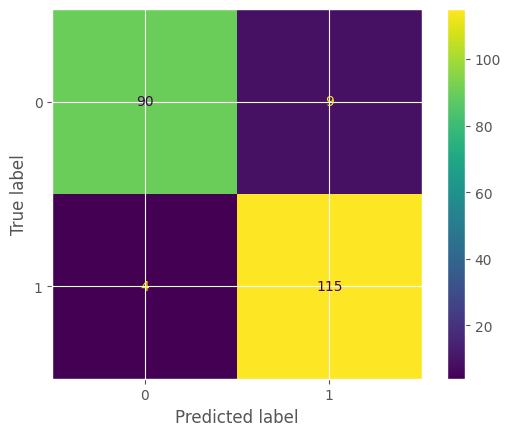

In [ ]:
class_names = ["Normal","Cataract"]

cm = confusion_matrix(y_test, m, labels=[0,1])
    
disp = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=class_names)
disp.plot()

plt.show()


### Learning Curves

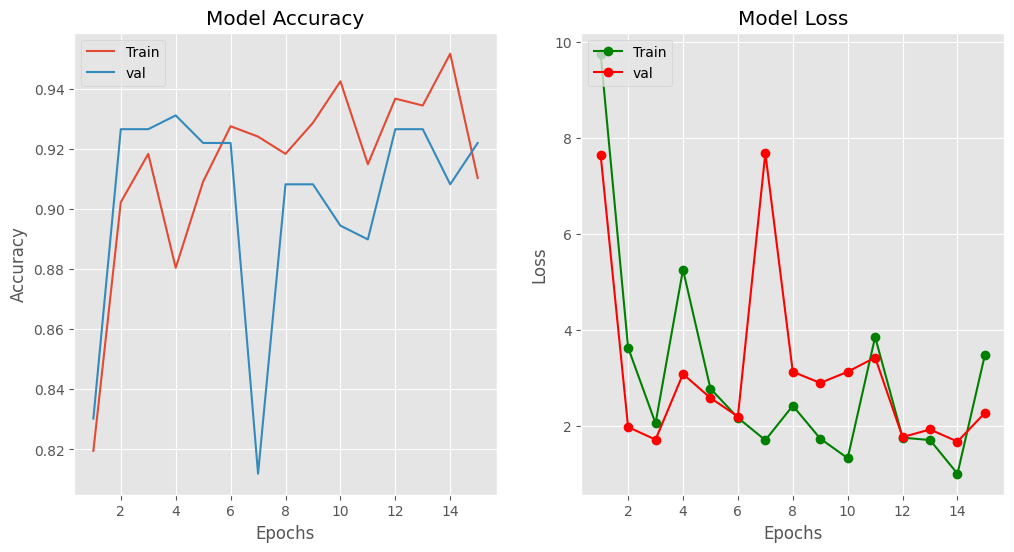

In [ ]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,16)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"])#,"go-")
plt.plot(epochs,history.history["val_accuracy"])#,"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

### Prediction

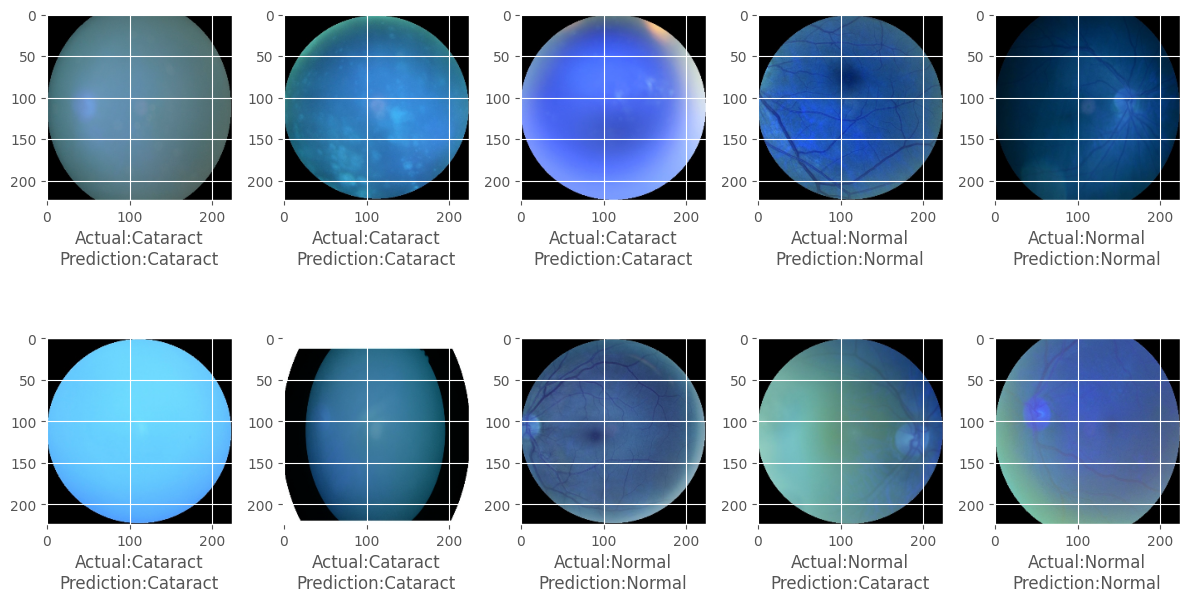

In [ ]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 

## ResNet Model

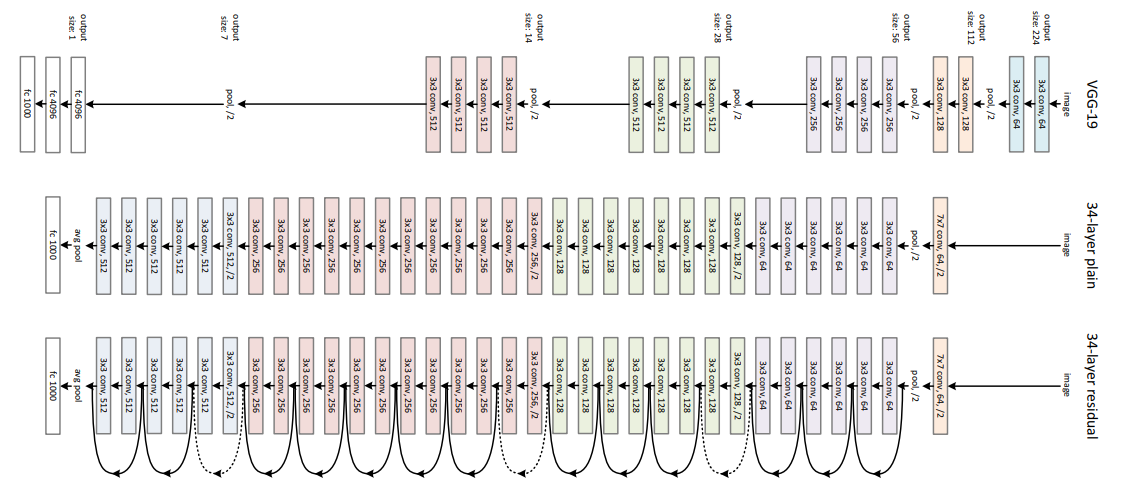

In [ ]:
resnet = tensorflow.keras.applications.ResNet50(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

for layer in resnet.layers:
    layer.trainable = False

def create_model():
  model = Sequential()
  model.add(resnet)
  model.add(Flatten())
  model.add(Dense(1,activation="sigmoid"))

  model.compile(optimizer= tensorflow.keras.optimizers.SGD(learning_rate=0.005) ,loss="binary_crossentropy",metrics=["accuracy"])

  return model

model = create_model()

model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_3 (Dense)             (None, 1)                 100353    
                                                                 
Total params: 23,688,065
Trainable params: 100,353
Non-trainable params: 23,587,712
_________________________________________________________________


### Training

In [ ]:
checkpoint_path = "r/content/drive/Shareddrives/BMIN_5220/Code/model/cataract_resnet_sgd_005.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
history = model.fit(train_datagen.flow(x_train,y_train,
                                       batch_size=32, 
                                       seed=27,
                                       shuffle=False),
                    epochs=15,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint])

Epoch 1/15
28/28 [==============================] - ETA: 0s - loss: 9.7595 - accuracy: 0.8195 
Epoch 1: saving model to r/content/drive/Shareddrives/BMIN_5220/Code/model/cataract_resnet_sgd_005.ckpt
28/28 [==============================] - 28s 862ms/step - loss: 9.7595 - accuracy: 0.8195 - val_loss: 7.6477 - val_accuracy: 0.8303
Epoch 2/15
28/28 [==============================] - ETA: 0s - loss: 3.6320 - accuracy: 0.9023
Epoch 2: saving model to r/content/drive/Shareddrives/BMIN_5220/Code/model/cataract_resnet_sgd_005.ckpt
28/28 [==============================] - 14s 492ms/step - loss: 3.6320 - accuracy: 0.9023 - val_loss: 1.9737 - val_accuracy: 0.9266
Epoch 3/15
28/28 [==============================] - ETA: 0s - loss: 2.0508 - accuracy: 0.9184
Epoch 3: saving model to r/content/drive/Shareddrives/BMIN_5220/Code/model/cataract_resnet_sgd_005.ckpt
28/28 [==============================] - 14s 508ms/step - loss: 2.0508 - accuracy: 0.9184 - val_loss: 1.7112 - val_accuracy: 0.9266
Epoch 4/1

### Evaluation

In [ ]:
loaded_model = create_model()

loaded_model.load_weights(checkpoint_path)

loss,accuracy = loaded_model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 [==============================] - 2s 90ms/step - loss: 1.3857 - accuracy: 0.9404
loss: 1.3856583833694458
Accuracy: 0.9403669834136963


In [ ]:
y_pred = loaded_model.predict(x_test) 
classes_x=np.argmax(y_pred,axis=1)

7/7 [==============================] - 1s 82ms/step


In [ ]:
m = [0 if i<0.5 else 1 for i in y_pred]

print(m)
y_pred = m

[1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1]


In [ ]:
accuracy_score(y_test,y_pred)

0.9403669724770642

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93        99
           1       0.93      0.97      0.95       119

    accuracy                           0.94       218
   macro avg       0.94      0.94      0.94       218
weighted avg       0.94      0.94      0.94       218



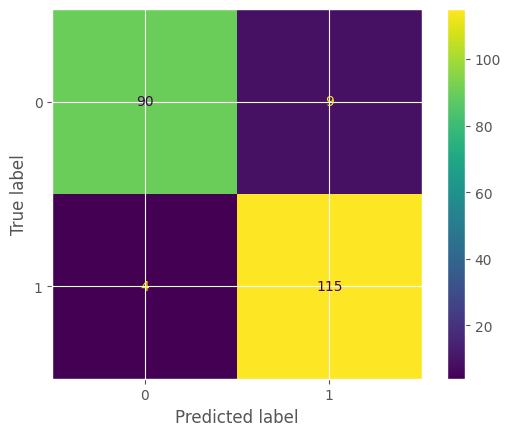

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = ["Normal","Cataract"]

cm = confusion_matrix(y_test, m, labels=[0,1])
    
disp = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=class_names)
disp.plot()

plt.show()

Learning Curves

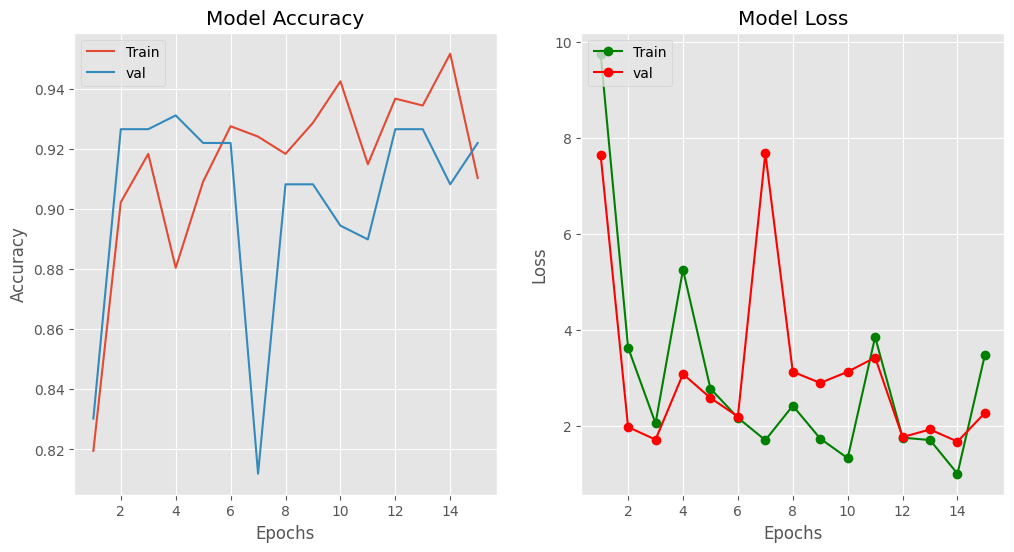

In [ ]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,16)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"])#,"go-")
plt.plot(epochs,history.history["val_accuracy"])#,"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

### Prediction

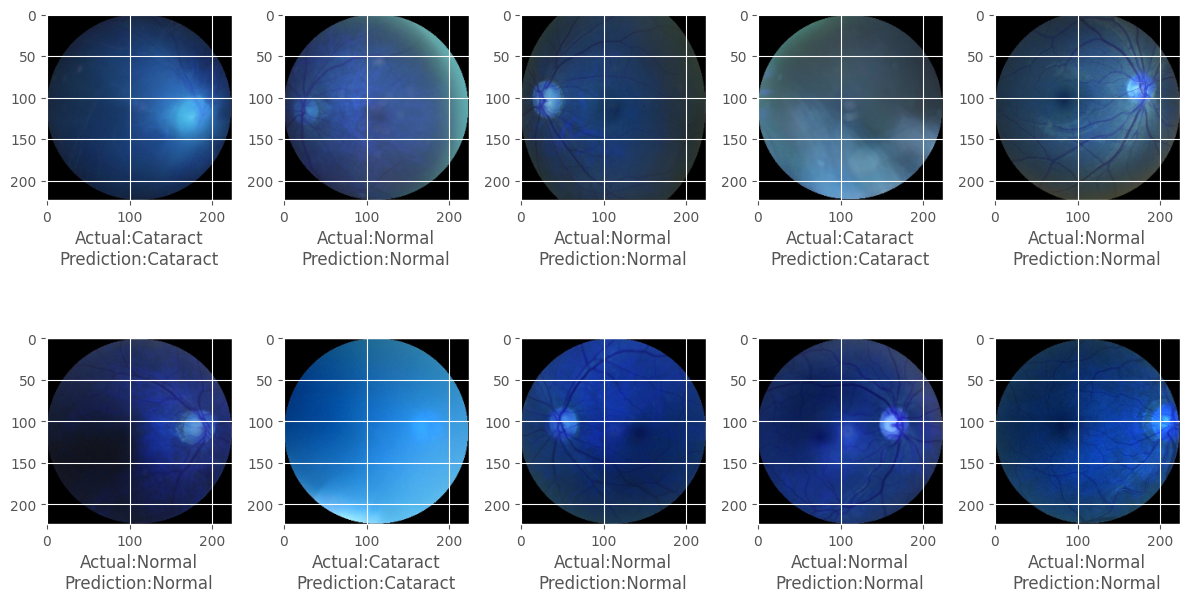

In [ ]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout()

# Conclusion

The models we used have worked with great accuracy. So from this it can concluded that we have accomplished the goal we had set out for. This will help the doctors to make more informed decisions. The patients will not only get an earlier dignosis but also a more accurate evaluation. This is because often the eye-disorders quite easliy mix up. For instance the catatract and gluacomo infected eye both show cloudiness but at slighlty different points. Work still has to be done to further fine-tune the model given the extra images in the dataset thanks to the augmentation. 